21.11.24 update: Permanently connect AOM to the setup. Therefore the PulseStreamer needs to be always on and running, even if all it does is stay perpetually on.

Notes

- Do not blindly hit run all; ensure that the correct blocks are running
- Restart kernel before re-running code
- Explicit laser off command at the bottom of the page

In [ ]:
import numpy as np
import pathlib
import pyvisa
import time
import matplotlib.pyplot as plt
import math
from datetime import datetime
import threading
import pandas as pd
import os

TODAY_STR = datetime.now().strftime("%d.%m.%Y") # Format the date as DD.MM.YYYY
print(f"\x1b[1;3;4;96mDate of running the code:\x1b[0m \x1b[1;3;4;92m{TODAY_STR}\x1b[0m")
print(f"Time of running the code: {datetime.now().strftime("%H:%M:%S")}")
print("\x1b[1;31mWait for it...\x1b[0m")

# Device communication - must always be run
rm = pyvisa.ResourceManager()
list_connections = rm.list_resources()      

# Check device connection
if list_connections != 0:
    print("Pyvisa running nominally")
else:
    raise ValueError("Connections not working")

Date of running the code: 22.11.2024
Time of running the code: 16:25:40
Wait for it...
Pyvisa running nominally


In [2]:
# # Laser connection. Laser is TSL
is_connect_success = False 
while not is_connect_success:
    try:
        TSL = rm.open_resource("TCPIP::169.254.82.30::5000::SOCKET", read_termination="\r")
        print(TSL.query("*IDN?"))
        print("\x1b[0;92mTSL Connection established\x1b[0m")
        is_connect_success = True
    except pyvisa.VisaIOError:
        print("Retrying...")
        time.sleep(0.5)

SANTEC,TSL-570,24070004,0026.0026.0011
TSL Connection established


In [ ]:
# # oscilloscope connection
# Open the connection to the oscilloscope using its IP address
oscilloscope = rm.open_resource('TCPIP::169.254.112.67::INSTR', open_timeout=5000) # For the RIGOL DHO1204 in A*STAR

# Send a command to verify connection (e.g., identify the instrument)
# Sanity check for successful communication with oscilloscope
response = oscilloscope.query('*IDN?')
print(response, end='')
print("\x1b[0;92mOscilloscope Connection established.\x1b[0m")

# # Oscilloscope configure settings
oscilloscope.write(':TIMebase:ROLL 0')      # Turn off roll

oscilloscope.write(':ACQuire:MDEPth 1M')    # Check again if this command is working! If not manually set MemDepth

oscilloscope.write(':CHANnel2:BWLimit 20M')     # Clean up the high frequency noise
oscilloscope.write(':CHANnel2:BWLimit ON')     

# Set time scale
oscilloscope.write(':TIMebase:MAIN:SCALe 0.0005')     
oscilloscope.write(':TIMebase:MAIN:OFFSet 0')

# Set voltage scale
oscilloscope.write(':CHANnel2:SCALe 0.005')      
oscilloscope.write(':CHANnel2:OFFSet 0')       # For viewing clarity

oscilloscope.write(':CHANnel1:DISPlay 0')       # No need trigger signal here
oscilloscope.write(':CHANnel2:DISPlay 1')       # Turn on display of channel 2

print()
print("Oscilloscope settings configured.")
print(f"The filter is set to {oscilloscope.query(':CHANnel2:BWLimit?')}")
print("\x1b[1;31mCheck settings again on oscilloscope screen, rerun cell if wrong.\x1b[0m")

RIGOL TECHNOLOGIES,DHO1204,HDO1B261900518,00.02.12
Oscilloscope Connection established.

Oscilloscope settings configured.
The filter is set to OFF

Check settings again on oscilloscope screen, rerun cell if wrong.


In [4]:
# # PulseStreamer connection - for permanent AOM on

# import API classes into the current namespace
from pulsestreamer import PulseStreamer, Sequence

# Connect to Pulse Streamer
ip = '169.254.8.2'  # Do not change this!!
ps = PulseStreamer(ip)

perpetual_on = False     # This is just for the AOM to be like it's not even there if set to True

# Create a sequence object
sequence = ps.createSequence()

# # on-off sequence creation
# Each time unit is 10**(-9) seconds
# Example: A pulse with 10µs (10000 units) HIGH (or 1) and 30µs (30000 units) LOW (or 0) levels

# Time period of one cycle in seconds, e.g. 1*10**(-6) is one microsecond
T = 0.5         # modify this according to what I want

# Duty ratio (fraction of on-time during one cycle). A float from 0 to 1.
D = 0.5         # modify this according to what I want

if perpetual_on is True:
    D = 1

if D > 1 or D < 0:
    raise ValueError("D must be between 0 and 1, inclusive.")

# Convert T into time units
pattern_T = math.ceil(T / (10**(-9)))
on_time = math.ceil(pattern_T * D)
off_time = math.ceil(pattern_T * (1-D))

pattern = [(on_time, 1), (off_time, 0)]

# Create sequence and assign pattern to digital channel 0
sequence.setDigital(0, pattern)

## Pattern implementation
# Stream the sequence and repeat it indefinitely
n_runs = PulseStreamer.REPEAT_INFINITELY
ps.stream(sequence, n_runs)

Connect to Pulse Streamer via JSON-RPC.
IP / Hostname: 169.254.8.2
Pulse Streamer 8/2 firmware: v1.7.2
Client software: v1.7.0


In [5]:
# Turn on the laser
WAV_START = 1540        # TODO: Calculate this and set this correctly!
laser_power = 13        # Set to the highest possible value due to significant losses

TSL.write(":WAVelength:SWEep 0")    # Engineering reset to regular, constant-on mode
time.sleep(0.1)
TSL.write(f":WAVelength {WAV_START}nm")
time.sleep(0.1)
TSL.write(f":POW {laser_power}")
time.sleep(0.1)

# print(TSL.query(":POWer:STATe?"))

if TSL.query(":SYSTem:ALERt?") == "No alerts.":
    print("Nominal laser operation")              
    print(f"\x1b[0;92mLaser configured to {WAV_START}nm at {laser_power}dBm\x1b[0m") 
else:
    print(TSL.query(":SYSTem:ALERt?"))
    print("Note that some time might be needed for laser to warm up; See page 101 of TSL manual")

Nominal laser operation
Laser configured to 1540nm at 13dBm


In [6]:
# # Data collection of optical absorption

def setup_trigger(trigger_level, trigger_source='CHAN2'):
    """Function to set up and enable triggering"""
    oscilloscope.write(" :TRIGger:MODE EDGE")
    oscilloscope.write(f':TRIGger:EDGE:SOURce {trigger_source}')
    oscilloscope.write(f':TRIGger:EDGE:LEVel {trigger_level}') 
    # Trying to catch falling edge, so must be negative slope
    oscilloscope.write(':TRIGger:EDGE:SLOPe NEGative')
    oscilloscope.write(':TRIGger:SWEep SINGle')
    

def plot_and_save_waveform(channels: list[int]):
    """Function to save the waveform as CSV file. """
    
    for ch in channels:
        # Select the channel
        oscilloscope.write(f':WAV:SOUR CHAN{ch}')

        # Set the waveform format to ASCII (can also use 'BYTE' or 'WORD' for binary)
        oscilloscope.write(':WAV:FORM ASCII')

        # Get the waveform data
        print(f"Querying waveform data for channel {ch}")
        data = oscilloscope.query(':WAV:DATA?')

        # Parse the data (it's returned as a comma-separated string in ASCII mode)
        waveform_data = np.array([float(i) for i in data.split(',')])
        waveforms[f"waveform_ch{ch}"] = waveform_data

        # Get the X-axis scale and position (Time per division, etc.)
        x_increment = float(oscilloscope.query(':WAV:XINC?'))
        x_origin = float(oscilloscope.query(':WAV:XOR?'))

        # Generate the time axis
        time_axis = np.linspace(x_origin, x_origin + x_increment * len(waveform_data), len(waveform_data))
        waveforms[f"time_axis_ch{ch}"] = time_axis

        # Generate a timestamp for the file name
        timestamp = datetime.now().strftime("%d.%m.%Y_%H.%M.%S")
        # Generate a datestamp for the overall folder name
        datestamp = datetime.now().strftime("%d.%m.%Y")
        
        # Define the folder path
        output_folder = f"C:/Users/groov/VSCode/CSV_Waveforms/{datestamp}/{datestamp}_T1_measurements"
        # Create the folder if it doesn't exist
        os.makedirs(output_folder, exist_ok=True)
        
        csvfilename = os.path.join(output_folder, f"{timestamp}_optical_at_{WAV_START}nm.csv")
        # opticalcsvfilenames.append(csvfilename)

        # Save the waveform data to a CSV file
        np.savetxt(csvfilename, np.column_stack((time_axis, waveform_data)), delimiter=",", header="Time, Amplitude")

        # Plot the waveform for visualization and sanity check
        plt.figure(figsize=(10, 6))
        for ch in channels:
            plt.plot(waveforms[f"time_axis_ch{ch}"],  waveforms[f"waveform_ch{ch}"], label=f"channel {ch}")
        plt.title(f"T1 curve at wavelength {WAV_START}nm")
        plt.xlabel("Time (s)")
        plt.ylabel("Amplitude (V)")
        plt.grid(True)
        plt.legend()
        # plt.savefig(f"waveform_channel_{channel}_{timestamp}.png")
        plt.show()


Triggered and stopped capture
Querying waveform data for channel 2


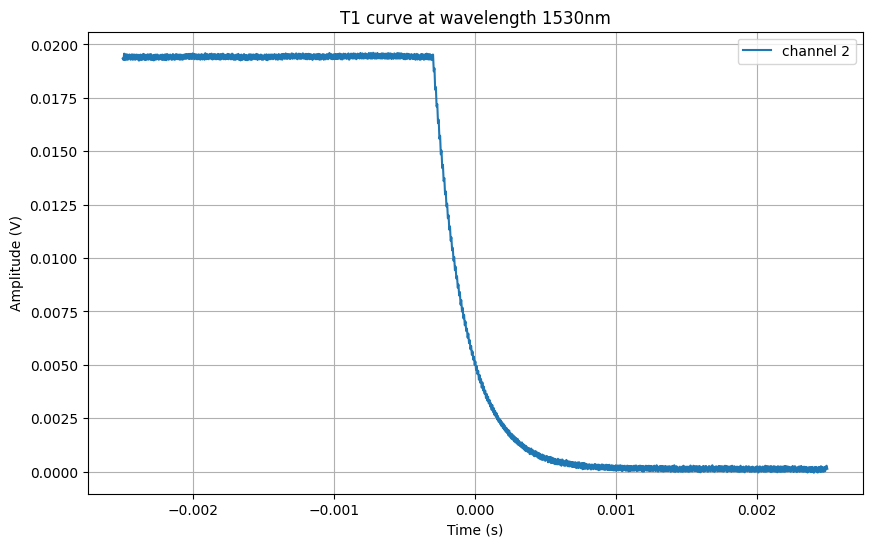

Triggered and stopped capture
Querying waveform data for channel 2


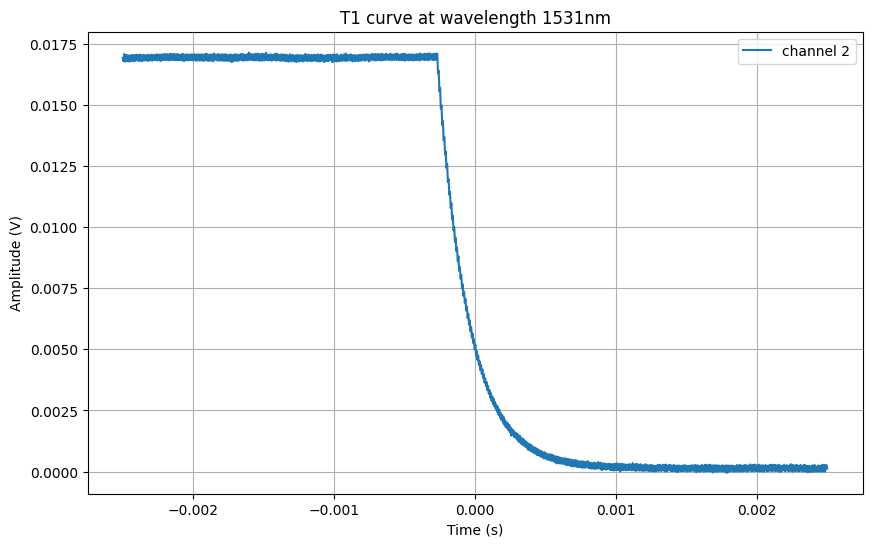

Triggered and stopped capture
Querying waveform data for channel 2


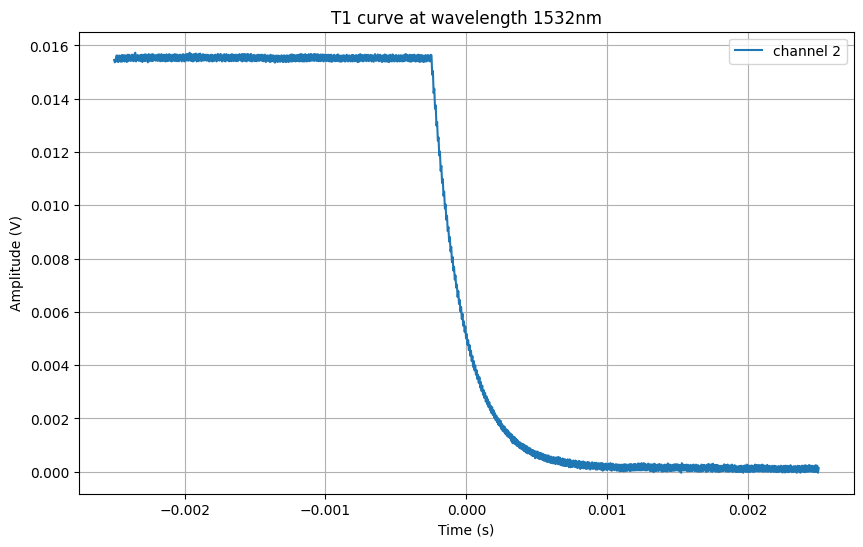

Triggered and stopped capture
Querying waveform data for channel 2


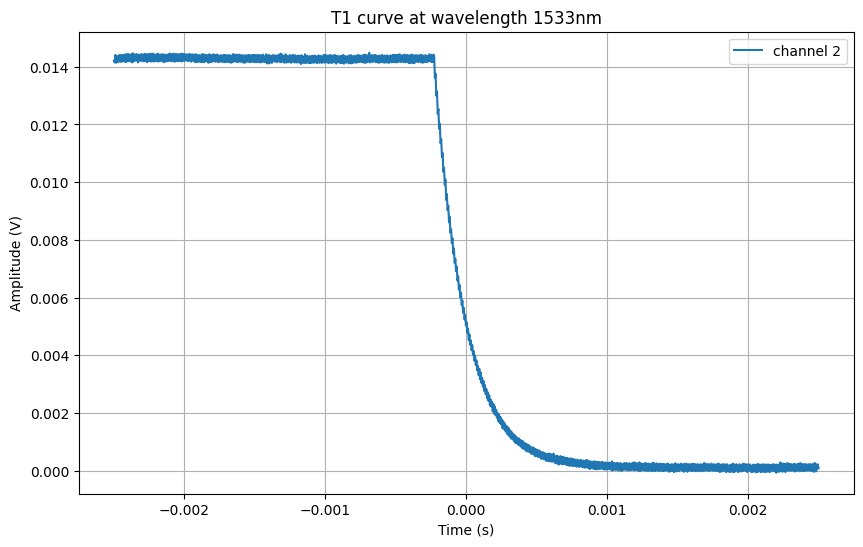

Triggered and stopped capture
Querying waveform data for channel 2


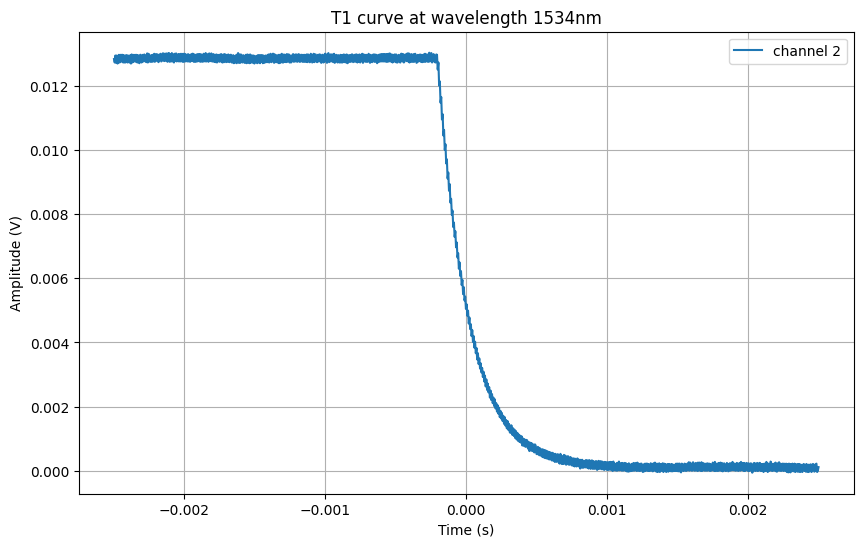

Triggered and stopped capture
Querying waveform data for channel 2


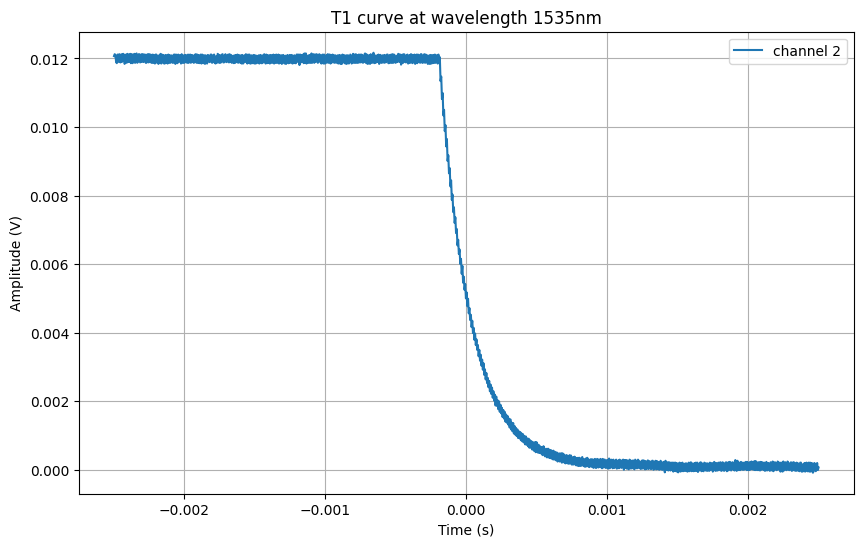

Triggered and stopped capture
Querying waveform data for channel 2


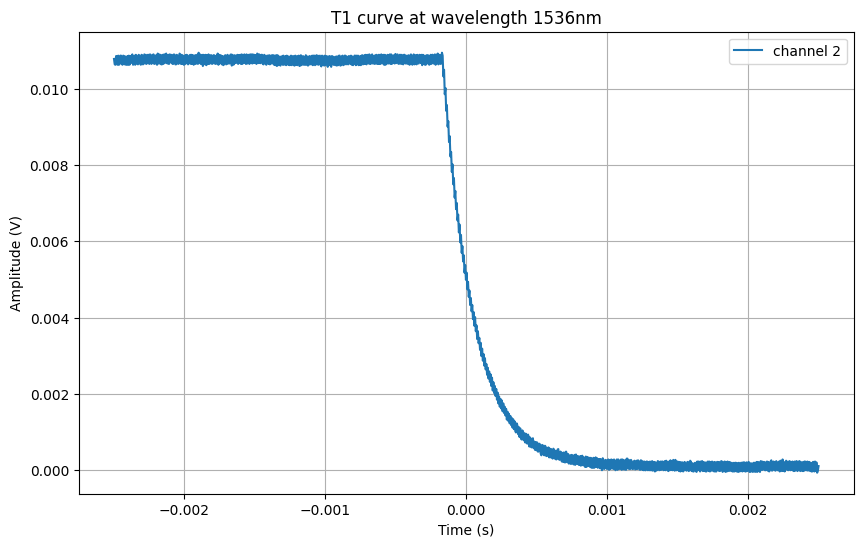

Triggered and stopped capture
Querying waveform data for channel 2


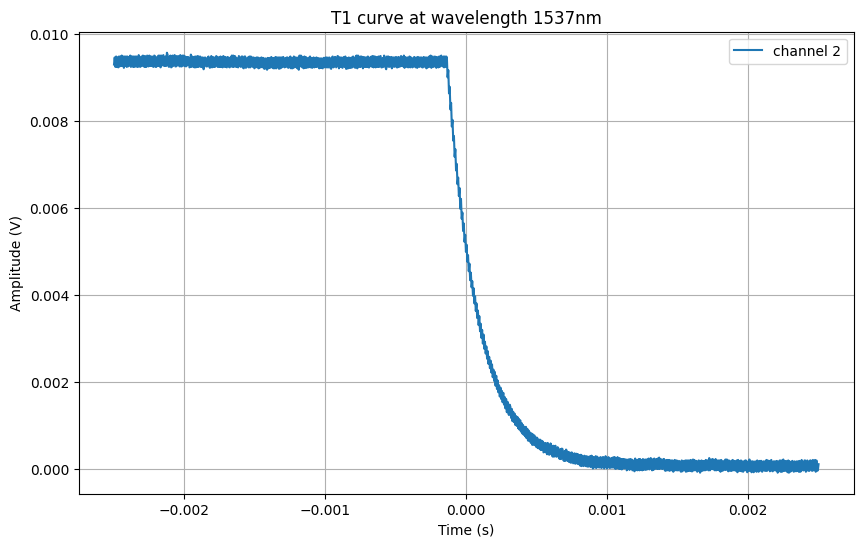

Triggered and stopped capture
Querying waveform data for channel 2


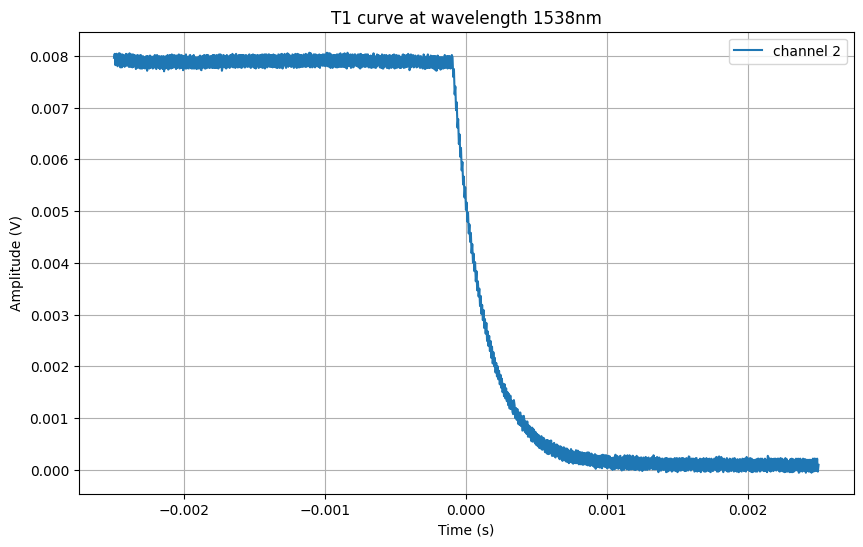

Triggered and stopped capture
Querying waveform data for channel 2


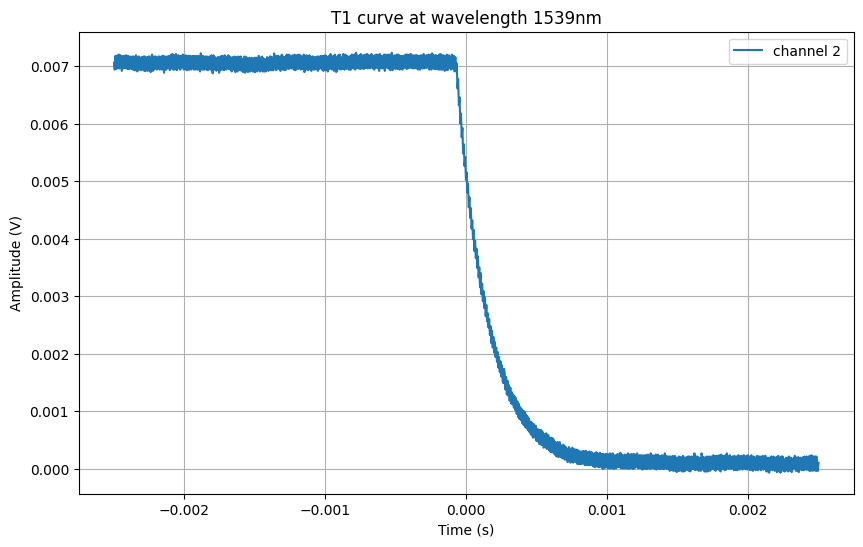

Triggered and stopped capture
Querying waveform data for channel 2


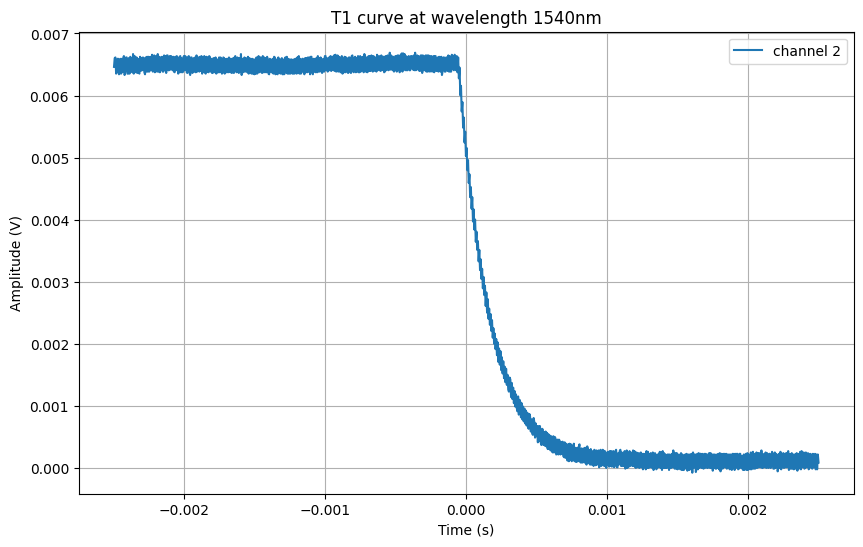

In [7]:
# Acquire data by performing iterative T1 measurement

waveforms = {}      # Initialise empty dictionary of waveforms for the plot_and_save_waveform function

for WAV_START in range(1530,1540+1):    # for sweep
#     Turn on laser to constant on mode
    TSL.write(":WAVelength:SWEep 0")
    time.sleep(0.1)
    TSL.write(f":WAVelength {WAV_START}nm")
    time.sleep(0.1)     
    TSL.write(":POWer:STATe 0") # Engineering reset
    time.sleep(0.1)
    TSL.write(":POWer:STATe 1")
    time.sleep(0.1)

    oscilloscope.write(':STOP') # Quickly "engineering reset" the oscilloscope
    time.sleep(0.1)   # Small delay to let oscilloscope settle before running and arming trigger
    # print("Oscilloscope reset and running")

    oscilloscope.write(':RUN') # Need oscilloscope to start running before it can capture anything
    time.sleep(0.1)   # The trigger will automatically start capturing once the trigger is detected
    # print("Oscilloscope still running")

    setup_trigger(trigger_level = 0.003)  

    while 1:
        if oscilloscope.query(':TRIGger:STATus?').strip() == 'TD' or oscilloscope.query(':TRIGger:STATus?').strip() == 'STOP':
            print("Triggered and stopped capture")
            plot_and_save_waveform(channels=[2])
            break

    

In [8]:
# # Explicit laser turn off
if TSL.query(":POWer:STATe?") != "+0":
    TSL.write(":POWer:STATe +0")
    time.sleep(0.1)